In [1]:
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../../')
sys.path.insert(0, '../../../')

import pickle as pk
import numpy as np
import os
import timeit
import matplotlib.pyplot as plt

%autosave 0

Autosave disabled


In [2]:
import lightgbm as gbm

/Users/chang/Library/Python/3.7/lib/python/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
from queries import Queries
from queries import concatenate
from queries import find_constant_features

from click_simulator import DependentClickModel

from utils.metric import ndcg_at_k
from utils.utils import evaluate_ranker

from rankers.click_lmart_ranker import ClickLMARTRanker
from rankers.lmart_ranker import LMARTRanker
from learners.online_learner import OnlineLTR
from learners.exploit_then_explore import ExploreThenExploitOLTR

In [ ]:
# Load Queries
queries_list = []
for name in ['train.txt', 'test.txt', 'vali.txt']:
    data_dir = '../../../datasets/MSLR10K/Fold1/' + name
    queries = Queries.load_from_text(data_dir)
    cls = find_constant_features(queries)
    queries.adjust(remove_features=cls, purge=True, scale=True)
    queries.save(data_dir[:-3]+'dat')
    queries_list.append(queries)
query_all = concatenate(queries_list)
query_all.save('../../../datasets/MSLR10K.dat')

In [5]:
data_dir = '../../../datasets/MSLR10K.dat'
queries = Queries.load(data_dir)

In [6]:
click_model = DependentClickModel('pure_cascade')

In [11]:
n_query = len(queries)
n_query_used = 10000
train_qset = queries[:int(0.4*n_query)][: n_query_used]
test_qset = queries[int(0.4*n_query): int(0.8*n_query)][: n_query_used]
valid_qset = queries[int(0.8*n_query):][: n_query_used]

# Offline LambdaMART

In [12]:
lmart_ranker_params = {
    'min_child_samples': 50,
    'min_child_weight': 0,
    'n_estimators': 500,
    'learning_rate': 0.02,
    'num_leaves': 400,
    'boosting_type': 'gbdt',
    'objective': 'lambdarank',
    'ndcg_eval_at': '5,10',
  }
lmart_fit_params = {
    'eval_metric': 'ndcg',
    'eval_at': 10,
    'verbose': 50,
}

eval_params = {
    'metric': ndcg_at_k,
    'cutoff': 10
}

num_iterations=10
num_train_queries=5

In [13]:
rankers = {
     'Click LambdaMART': ClickLMARTRanker(
      train_qset, valid_qset, test_qset,
      lmart_ranker_params, lmart_fit_params, click_model=click_model,
      total_number_of_clicked_queries=n_query_used),
    'Click LambdaMART Random': ClickLMARTRanker(
      train_qset, valid_qset, test_qset,
      lmart_ranker_params, lmart_fit_params, click_model=click_model,
      total_number_of_clicked_queries=n_query_used, learn_from_random=True),
    'Offline LambdaMART': LMARTRanker(
      train_qset, valid_qset, test_qset,
      lmart_ranker_params, lmart_fit_params),
 }

[50]	valid_0's ndcg@10: 0.432306
[100]	valid_0's ndcg@10: 0.445738
[150]	valid_0's ndcg@10: 0.45456
[200]	valid_0's ndcg@10: 0.457156
[250]	valid_0's ndcg@10: 0.458493
[300]	valid_0's ndcg@10: 0.458774
[350]	valid_0's ndcg@10: 0.458793
[400]	valid_0's ndcg@10: 0.457874
[450]	valid_0's ndcg@10: 0.458315
[500]	valid_0's ndcg@10: 0.456499
[50]	valid_0's ndcg@10: 0.808822
[100]	valid_0's ndcg@10: 0.807776
[150]	valid_0's ndcg@10: 0.810022
[200]	valid_0's ndcg@10: 0.811958
[250]	valid_0's ndcg@10: 0.817442
[300]	valid_0's ndcg@10: 0.817626
[350]	valid_0's ndcg@10: 0.819314
[400]	valid_0's ndcg@10: 0.820169
[450]	valid_0's ndcg@10: 0.820915
[500]	valid_0's ndcg@10: 0.821925
[50]	valid_0's ndcg@10: 0.707528
[100]	valid_0's ndcg@10: 0.709955
[150]	valid_0's ndcg@10: 0.710639
[200]	valid_0's ndcg@10: 0.7092
[250]	valid_0's ndcg@10: 0.708837
[300]	valid_0's ndcg@10: 0.709956
[350]	valid_0's ndcg@10: 0.711201
[400]	valid_0's ndcg@10: 0.709317
[450]	valid_0's ndcg@10: 0.709423
[500]	valid_0's ndcg

In [14]:
for ranker in rankers:
    print(ranker, evaluate_ranker(test_qset, rankers[ranker], eval_params))

Click LambdaMART 0.156550988378849
Click LambdaMART Random 0.3403714564675741
Offline LambdaMART 0.47290357213558776


In [9]:
for ranker in rankers:
    print(ranker, evaluate_ranker(test_qset, rankers[ranker], eval_params))

Click LambdaMART 0.14448130143533677
Click LambdaMART Random 0.32218318543834934
Offline LambdaMART 0.4743506668434501


In [36]:
clicks=[]
rk = [1,3,4,2,0]

for i in range(10000):
    clicks.append(click_model.get_click(rk))
print(np.mean(clicks, axis=0))

[0.1982 0.7984 1.     0.3966 0.    ]


In [116]:
self = rankers['Click LambdaMART Random']
self.click_model = click_model

In [117]:
total_number_of_clicked_queries=10000
"""
  Train the ranker on the click training set
"""
self.num_training_queries = {
    'train': int(.6 * total_number_of_clicked_queries),
    'valid': int(.2 * total_number_of_clicked_queries),
    'test': int(.2 * total_number_of_clicked_queries),
    }
self.click_training_data = {}
l = {}
for data in ['train', 'valid', 'test']:
    query_ids, labels, rankings = get_labels_and_rankings(self, self.offline_ranker, self.num_training_queries[data], data)
    clicks = self.apply_click_model_to_labels_and_scores(self.click_model,
                                                       labels,
                                                       rankings)
    self.click_training_data[data] = \
    self.generate_training_data_from_clicks(query_ids, clicks,
                                            rankings, data)
    l[data]=labels
features = {}
labels_dict = {}
query_group = {}
for data in ['train', 'valid', 'test']:
    indices = self.click_training_data[data][0]
    features[data] = np.concatenate([self.offline_qset[data].feature_vectors[idx] for idx in indices])
    labels_dict[data] = self.click_training_data[data][1]
    query_group[data] = self.click_training_data[data][2]
# self.click_ranker.fit(X=features['train'], y=labels['train'],
#                       group=query_group['train'],
#                       eval_set=[(features['valid'], labels['valid'])],
#                       eval_group=[query_group['valid']],
#                       **self.fit_params)

In [119]:
print(sum(labels_dict['test']), len(labels_dict['test']), sum(labels_dict['test'])/len(labels_dict['test']))

3850 22929 0.16790963408783635


In [109]:
print(sum(labels_dict['test']), len(labels_dict['test']))

67820 447653


In [111]:
p_map = self.click_model.c_prob
p_l=[p_map[lq] for lq in l['test']]

In [114]:
sum([sum(p) for p in p_l])

67934.40000000008

In [19]:
COLOR_DICT = (
        "#FF0000",  # red
        "#FFFF00",  # gold
        "#A8FF33",  # light green
        "#00FFFF",  # cyan
        "#808080",  # grey
        "#000FFF",  # deep sky blue
        "#9932CC",  # dark orchid
        "#008000",  # green
        "#556B2F",
        "#6B8E23",
        "#7CFC00",
        "#7FFF00",
        "#ADFF2F",
        "#006400",
        "#228B22",
        "#00FF00",
        "#32CD32",
        "#000080",
        "#008080",
        "#800080",
        "#008000",
        "#808000",
        "#808080",
        '#800000',
        "#FF00FF",
        "#00FFFF",
        "#FFFF00",
        "#0000FF",
        "#00FF00",
        "#FF0000",
        )

In [15]:
eval_results= pk.load(open('../../../results/mslr30k.pkl', 'rb'))

Saving a plot of the results to /tmp/plot.png


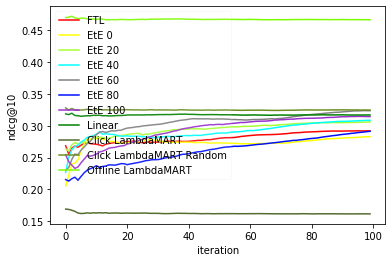

In [19]:
out_path='/tmp/plot.png'
fig, ax = plt.subplots()
i = 0
for ranker, metrics in eval_results.items():
    rt = np.cumsum(metrics)
    rt = rt / np.arange(1, rt.shape[0]+1)
    ax.plot(rt, label=ranker, color=COLOR_DICT[i])
    i+=1
plt.xlabel('iteration')
plt.ylabel('ndcg@10')
print('Saving a plot of the results to', out_path)
plt.legend(loc='upper left', framealpha=0.1)
fig.savefig(out_path, dpi=1200)